In [1]:
cd ..

/experiments_motion


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
#sys.path.append(os.path.join(MODEL_PATH, 'Motion'))
#print(os.path.join(MODEL_PATH, 'Motion'))
sys.path.append('./Motion')

In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import yaml
from tqdm import tqdm
from IPython.display import display, HTML

In [5]:
from motion import Motion
from motion import Quaternion
from h36m.skeleton import H36MSkeleton
from h36m.dataset.h36m_torch_dataset import H36MTorchDataset
from h36m.dataset.h36m_dataset import H36MDataset
from h36m.dataset.h36m_test_dataset import H36MTestDataset
from misc.helper import add_static_nodes

In [6]:
import matplotlib.pyplot as plt
import time

In [7]:
%matplotlib notebook

In [8]:
from metrics import MeanAngleL2Error, MeanPerJointPositionError

# Evaluation of Motion on H3.6M dataset

# Load H3.6M Skeleton

In [9]:
# Load skeleton configuration
with open('./config/h36m_skeleton.yaml', 'r') as stream:
    skeleton = H36MSkeleton(**yaml.safe_load(stream))

## Load the Model

In [10]:
MODEL_PATH = './output/h36m/node_dropout/'
CHECKPOINT = 'model'
CHECKPOINT_PATH = os.path.join(MODEL_PATH, CHECKPOINT + '.pth.tar')

In [11]:
# Load model config
with open(os.path.join(MODEL_PATH, 'config.yaml'), 'r') as file:
    model_config = yaml.safe_load(file)

In [12]:
model = Motion(skeleton, T=skeleton.nodes_type_id_dynamic, **model_config)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
model.eval()
print('Model Loaded')

Model Loaded


## Load Evaluation Data

In [14]:
DATA_PATH = './data/processed/h3.6m.npz'

In [15]:
h36m_dataset = H36MDataset(DATA_PATH, dataset_fps=50, dataset_downsample_factor=2)

In [16]:
dataset_eval = H36MTestDataset(h36m_dataset,
                                subjects=['S5'],
                                action='walking',
                                history_length=50,
                                prediction_horizon=25)

## Run Model

In [17]:
sequence = 6
with torch.no_grad():
    x, y = dataset_eval[sequence]

    x = x.unsqueeze(0)
    y = y.unsqueeze(0)

    # Remove static nodes
    x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

    # Run Model 
    p_q, _, _, _ = model(x_dynamic, ph=25)

    # The mode of the Distribution are the rotations
    q_mode = p_q.weighted_mean
    
    q_samp = p_q.sample((50,))
    
    # Fix for viz
    q_mode = Quaternion(q_mode).axis_angle
    q_mode = Quaternion(axis=-q_mode, angle=q_mode.norm(dim=-1)).q
    q_samp = Quaternion(q_samp).axis_angle
    q_samp = Quaternion(axis=-q_samp, angle=q_samp.norm(dim=-1)).q
    
    # Add static rotations q = [1., 0., 0., 0.]
    q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)
    q_samp_all = add_static_nodes(q_samp, skeleton.static_nodes, skeleton.dynamic_nodes)

    pos_mode_all = skeleton(q_mode_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
    pos_mode_all_samp = skeleton(q_samp_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
    
    # Fix for viz
    y = Quaternion(y).axis_angle
    y = Quaternion(axis=-y, angle=y.norm(dim=-1)).q
    pos_y = skeleton(y.view(-1, 32, 4)).view(-1, 25, 32, 3)

In [18]:
p_q_no_occ = p_q
pos_mode_all_no_occ = pos_mode_all
pos_mode_all_no_occ_samp = pos_mode_all_samp

In [19]:
sequence = 6
with torch.no_grad():
    x, y = dataset_eval[sequence]
    
    # Occlude right leg
    x[0:, 1:6] = 0.
    x[0:, 1:6, 0] = 1.

    x = x.unsqueeze(0)
    y = y.unsqueeze(0)

    # Remove static nodes
    x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

    # Run Model 
    p_q, _, _, _ = model(x_dynamic, ph=25)

    # The mode of the Distribution are the rotations
    q_mode = p_q.weighted_mean
    
    q_samp = p_q.sample((50,))
    
    # Fix for viz
    q_mode = Quaternion(q_mode).axis_angle
    q_mode = Quaternion(axis=-q_mode, angle=q_mode.norm(dim=-1)).q
    q_samp = Quaternion(q_samp).axis_angle
    q_samp = Quaternion(axis=-q_samp, angle=q_samp.norm(dim=-1)).q
    
    # Add static rotations q = [1., 0., 0., 0.]
    q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)
    q_samp_all = add_static_nodes(q_samp, skeleton.static_nodes, skeleton.dynamic_nodes)

    pos_mode_all = skeleton(q_mode_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
    pos_mode_all_samp = skeleton(q_samp_all.view(-1, 32, 4)).view(-1, 25, 32, 3)
    
    # Fix for viz
    y = Quaternion(y).axis_angle
    y = Quaternion(axis=-y, angle=y.norm(dim=-1)).q
    pos_y = skeleton(y.view(-1, 32, 4)).view(-1, 25, 32, 3)

In [20]:
p_q_occ = p_q
pos_mode_all_occ = pos_mode_all
pos_mode_all_occ_samp = pos_mode_all_samp

<IPython.core.display.Javascript object>


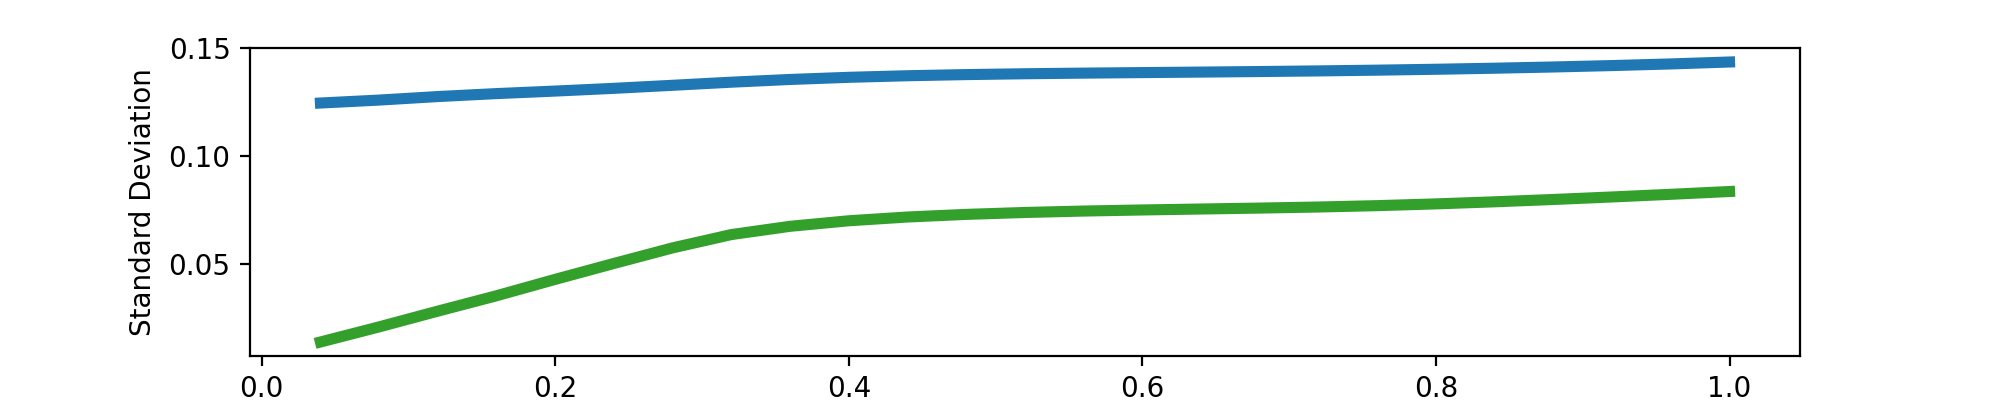

In [28]:
t = np.arange(1, 26) * 0.04
fig, axs = plt.subplots(1, 1, figsize=(10,2))
axs.plot(t, p_q_no_occ.component_distribution.integrated.std[0][:, :2].mean(dim=-1).mean(dim=-1).mean(dim=-1), c='#33A02C', linewidth=4)
axs.plot(t, p_q_occ.component_distribution.integrated.std[0][:, :2].mean(dim=-1).mean(dim=-1).mean(dim=-1), c='#1F78B4', linewidth=4)

axs.set_ylabel('Standard Deviation')
axs.set_xlabel('t [s]')


from matplotlib.lines import Line2D
colors = ['#33A02C', '#1F78B4']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Perfect Data', 'Occlusion']
fig.legend(lines, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.3))
fig.savefig('occlusion.pdf', bbox_inches='tight', dpi=300)
fig.show()

<IPython.core.display.Javascript object>


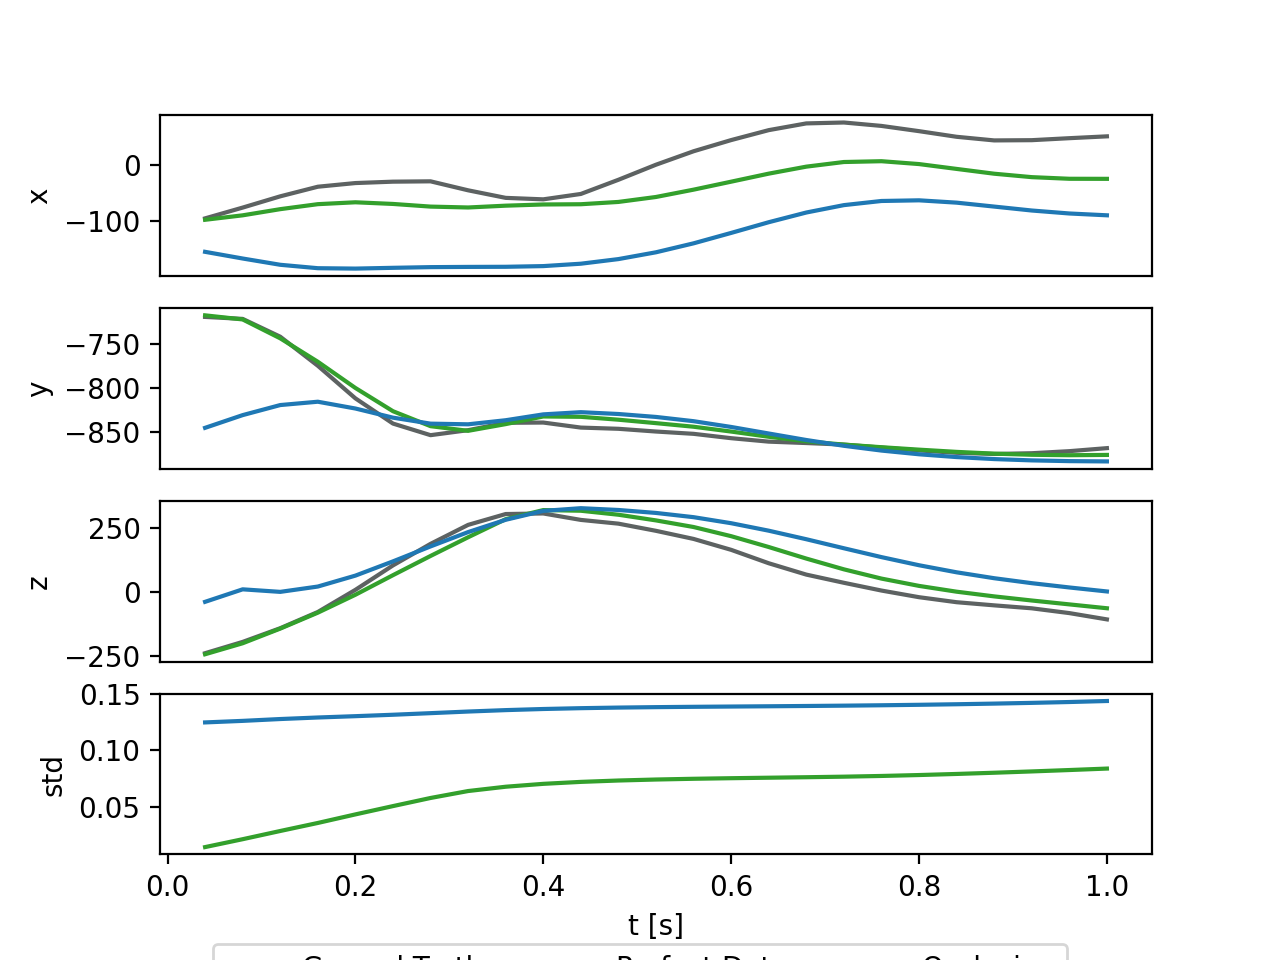

In [23]:
t = np.arange(1, 26) * 0.04
fig, axs = plt.subplots(4, 1)
# Plot Akle
axs[0].plot(t, pos_y[0, :, 3, 0], c='#5D6262')
axs[0].plot(t, pos_mode_all_no_occ[0, :, 3, 0], c='#33A02C')
axs[0].plot(t, pos_mode_all_occ[0, :, 3, 0], c='#1F78B4')
axs[1].plot(t, pos_y[0, :, 3, 1], c='#5D6262')
axs[1].plot(t, pos_mode_all_no_occ[0, :, 3, 1], c='#33A02C')
axs[1].plot(t, pos_mode_all_occ[0, :, 3, 1], c='#1F78B4')
axs[2].plot(t, pos_y[0, :, 3, 2], c='#5D6262')
axs[2].plot(t, pos_mode_all_no_occ[0, :, 3, 2], c='#33A02C')
axs[2].plot(t, pos_mode_all_occ[0, :, 3, 2], c='#1F78B4')

#axs[3].plot(t, -p_q_no_occ.log_prob(p_q_no_occ.mode)[0][:, :2].mean(dim=-1), c='#33A02C')
#axs[3].plot(t, -p_q_occ.log_prob(p_q_occ.mode)[0][:, :2].mean(dim=-1), c='#1F78B4')
axs[3].plot(t, p_q_no_occ.component_distribution.integrated.std[0][:, :2].mean(dim=-1).mean(dim=-1).mean(dim=-1), c='#33A02C')
axs[3].plot(t, p_q_occ.component_distribution.integrated.std[0][:, :2].mean(dim=-1).mean(dim=-1).mean(dim=-1), c='#1F78B4')



axs[0].set_xticks([])
axs[0].set_ylabel('x')
#axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_ylabel('y')
#axs[1].set_yticks([])
axs[2].set_xticks([])
#axs[2].set_yticks([])
axs[2].set_ylabel('z')
#axs[3].set_yticks([])
axs[3].set_ylabel('std')
axs[3].set_xlabel('t [s]')


from matplotlib.lines import Line2D
colors = ['#5D6262', '#33A02C', '#1F78B4']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['Ground Truth', 'Perfect Data', 'Occlusion']
fig.legend(lines, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.savefig('occlusion.pdf', bbox_inches='tight', dpi=300)
fig.show()

In [26]:
pos_mode_all_occ_samp.shape

torch.Size([50, 25, 32, 3])

<IPython.core.display.Javascript object>


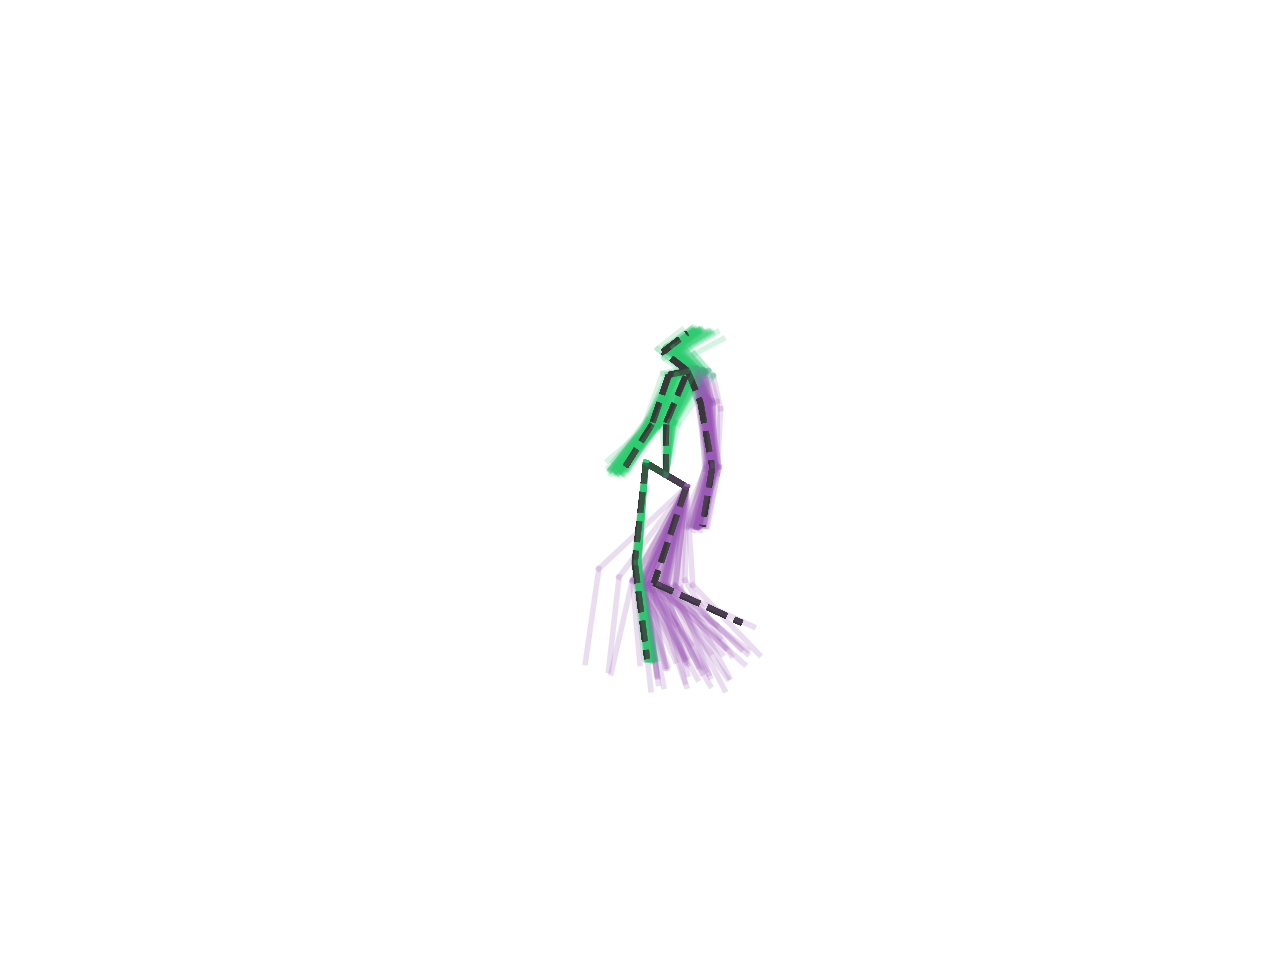

/tmp/ipykernel_13460/1457726805.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='3d')


In [53]:
t = 0
fig = plt.figure()
ax = plt.gca(projection='3d')

for i in range(50):
    ob = Ax3DPose(ax)
    ob.update(pos_y[0, t].numpy(), pos_mode_all_occ_samp[i, t].numpy())
    
ax.get_legend().remove()
plt.axis('off')
ax.view_init(20, 150)

In [54]:
fig.savefig('occlusion_0.pdf', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


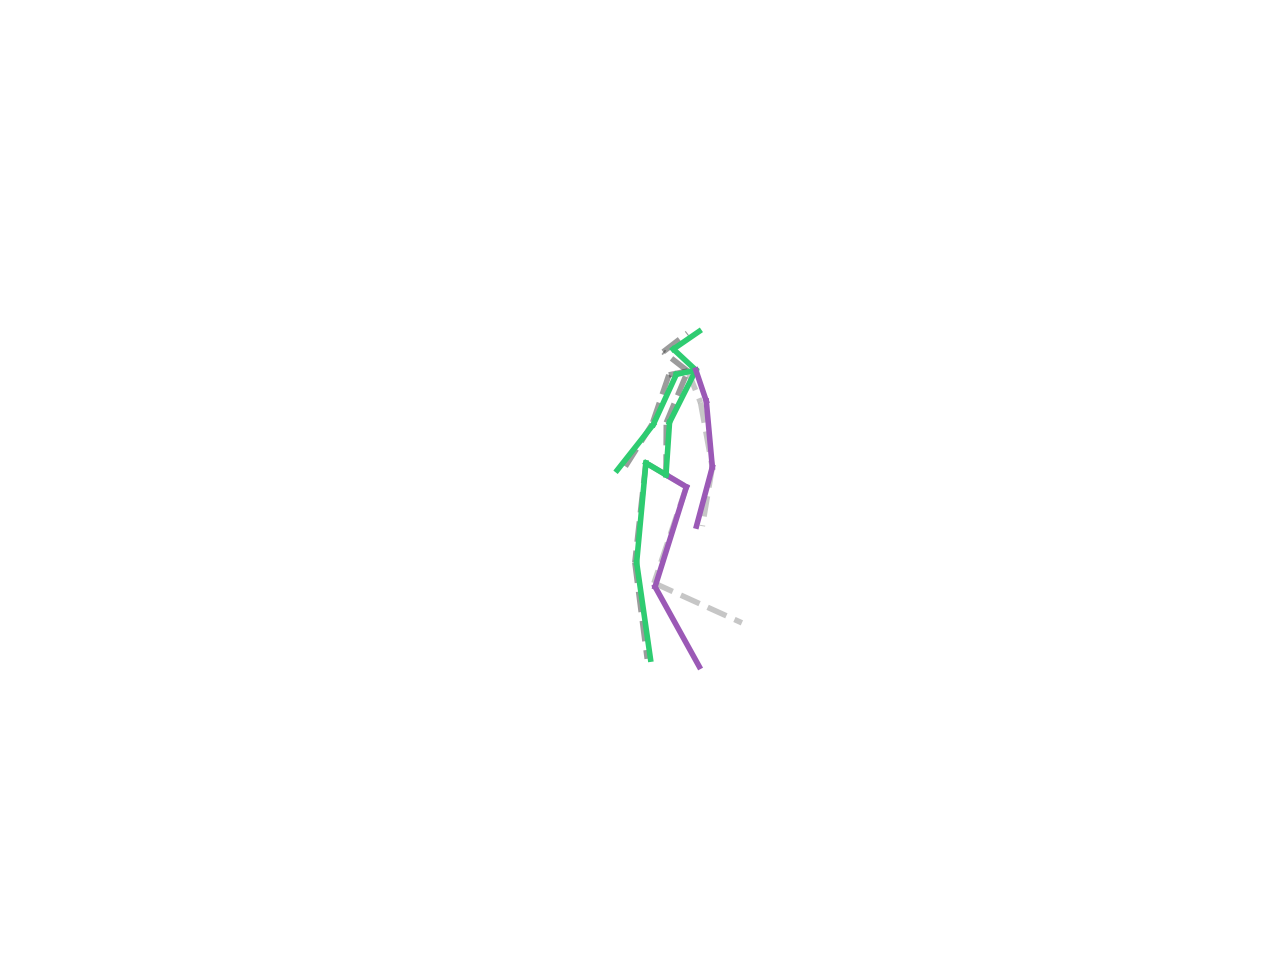

/tmp/ipykernel_13460/826785725.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='3d')


In [32]:
fig = plt.figure()
ax = plt.gca(projection='3d')
ob = Ax3DPose(ax)
i = 0
ob.update(pos_y[0, i].numpy(), pos_mode_all_occ[0, i].numpy())

fig.canvas.draw()
plt.axis('off')
ax.get_legend().remove()
ax.view_init(20, 150)

In [112]:
fig.savefig('occlusion_0.pdf', bbox_inches='tight', dpi=300)

In [46]:
class Ax3DPose(object):
    def __init__(self, ax, lcolor="#3498db", rcolor="#e74c3c", label=['GT', 'Pred']):
        """
        Create a 3d pose visualizer that can be updated with new poses.

        Args
          ax: 3d axis to plot the 3d pose on
          lcolor: String. Colour for the left part of the body
          rcolor: String. Colour for the right part of the body
        """

        # Start and endpoints of our representation
        self.I = np.array([1, 2, 3, 1, 7, 8, 1, 13, 14, 15, 14, 18, 19, 14, 26, 27]) - 1
        self.J = np.array([2, 3, 4, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 26, 27, 28]) - 1
        # Left / right indicator
        self.LR = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
        self.ax = ax

        vals = np.zeros((32, 3))

        # Make connection matrix
        self.plots = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            z = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            y = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if i == 0:
                self.plots.append(
                    self.ax.plot(x, z, y, lw=2, linestyle='--', c=rcolor if self.LR[i] else lcolor, label=label[0]))
            else:
                self.plots.append(self.ax.plot(x, y, z, lw=2, linestyle='--', c=rcolor if self.LR[i] else lcolor))

        self.plots_pred = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            z = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            y = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if i == 0:
                self.plots_pred.append(self.ax.plot(x, y, z, lw=2, c=rcolor if self.LR[i] else lcolor, label=label[1]))
            else:
                self.plots_pred.append(self.ax.plot(x, y, z, lw=2, c=rcolor if self.LR[i] else lcolor))

        self.ax.set_xlabel("x")
        self.ax.set_ylabel("y")
        self.ax.set_zlabel("z")
        # self.ax.set_axis_off()
        # self.ax.axes.get_xaxis().set_visible(False)
        # self.axes.get_yaxis().set_visible(False)
        self.ax.legend(loc='lower left')
        self.ax.view_init(20, 90)

    def update(self, gt_channels, pred_channels):
        """
        Update the plotted 3d pose.

        Args
          channels: 96-dim long np array. The pose to plot.
          lcolor: String. Colour for the left part of the body.
          rcolor: String. Colour for the right part of the body.
        Returns
          Nothing. Simply updates the axis with the new pose.
        """
        assert gt_channels.size == 96, "channels should have 96 entries, it has %d instead" % gt_channels.size
        gt_vals = np.reshape(gt_channels, (32, -1))
        lcolor = "#383838"
        rcolor = "#383838"
        for i in np.arange(len(self.I)):
            x = np.array([gt_vals[self.I[i], 0], gt_vals[self.J[i], 0]])
            z = np.array([gt_vals[self.I[i], 1], gt_vals[self.J[i], 1]])
            y = np.array([gt_vals[self.I[i], 2], gt_vals[self.J[i], 2]])
            self.plots[i][0].set_xdata(x)
            self.plots[i][0].set_ydata(y)
            self.plots[i][0].set_3d_properties(z)
            self.plots[i][0].set_color(lcolor if self.LR[i] else rcolor)
            self.plots[i][0].set_alpha(1.0)

        assert pred_channels.size == 96, "channels should have 96 entries, it has %d instead" % pred_channels.size
        pred_vals = np.reshape(pred_channels, (32, -1))
        lcolor = "#9b59b6"
        rcolor = "#2ecc71"
        for i in np.arange(len(self.I)):
            x = np.array([pred_vals[self.I[i], 0], pred_vals[self.J[i], 0]])
            z = np.array([pred_vals[self.I[i], 1], pred_vals[self.J[i], 1]])
            y = np.array([pred_vals[self.I[i], 2], pred_vals[self.J[i], 2]])
            self.plots_pred[i][0].set_xdata(x)
            self.plots_pred[i][0].set_ydata(y)
            self.plots_pred[i][0].set_3d_properties(z)
            self.plots_pred[i][0].set_color(lcolor if self.LR[i] else rcolor)
            self.plots_pred[i][0].set_alpha(0.2)

        r = 750
        xroot, yroot, zroot = gt_vals[0, 0], gt_vals[0, 1], gt_vals[0, 2]
        self.ax.set_xlim3d([-r + xroot, r + xroot])
        self.ax.set_zlim3d([-r + zroot, r + zroot])
        self.ax.set_ylim3d([-r + yroot, r + yroot])
        self.ax.set_aspect('auto')